In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

In [182]:
#Load dataset
#df = pd.read_csv("../../0_DataPreparation/initialdata/transformed_data.csv")
df = pd.read_csv("../../0_DataPreparation/initialdata/merged_data_temperature+holidays+weather_impressions.csv")

#Ensure the 'Datum' column is in datetime format
df['Datum'] = pd.to_datetime(df['Datum'])
df['Weekday'] = df['Datum'].dt.day_name()

# replace nan with 0
df['KielerWoche'].fillna(0, inplace=True) 

#Define time ranges
train_start = '2013-07-01'
train_end = '2017-07-31'
val_start = '2017-08-01'
val_end = '2018-07-31'
test_start = '2018-08-01'
test_end = '2019-07-30'

#Split data
train_data = df[(df['Datum'] >= train_start) & (df['Datum'] <= train_end)]
validation_data = df[(df['Datum'] >= val_start) & (df['Datum'] <= val_end)]
test_data = df[(df['Datum'] >= test_start) & (df['Datum'] <= test_end)]

#Optional: print shapes
print("Train shape:", train_data.shape)
print("Validation shape:", validation_data.shape)
print("Test shape:", test_data.shape)

Train shape: (7517, 15)
Validation shape: (1839, 15)
Test shape: (351, 15)


/tmp/ipykernel_1619/959037608.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['KielerWoche'].fillna(0, inplace=True)


In [183]:
Y = train_data['Umsatz']
X = sm.add_constant(
	pd.get_dummies(train_data['Warengruppe'], drop_first=True, dtype=int)
	.join(pd.get_dummies(train_data['Weekday'], drop_first=True, dtype=int))
    .join(train_data['Temperatur'])
    .join(train_data['Windgeschwindigkeit'])
)

# Drop rows where either X or Y is NaN
valid_idx = Y.notna() & X.notna().all(axis=1)
Y_clean = Y[valid_idx]
X_clean = X[valid_idx]

# change indices so that they start from 0
Y_clean.index = range(len(Y_clean))
X_clean.index = range(len(X_clean))

# Fit the model
model = sm.OLS(Y_clean, X_clean)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     1434.
Date:                Mon, 02 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:21:46   Log-Likelihood:                -43341.
No. Observations:                7487   AIC:                         8.671e+04
Df Residuals:                    7473   BIC:                         8.681e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  58.6458    

In [184]:
predicted = results.predict(X_clean)
actual = Y_clean
residuals = actual - predicted

comparison_df = pd.DataFrame({
    'Predicted': predicted,
    'Actual': actual,
    'Residuals': residuals
})

print("Table (Head) to compare predicted and actual values:\n", comparison_df.head())

Table (Head) to compare predicted and actual values:
     Predicted  Actual   Residuals
0  131.899883  148.83   16.930117
1  421.063894  535.86  114.796106
2  174.656194  201.20   26.543806
3   98.811799   65.89  -32.921799
4  291.423305  317.48   26.056695


In [185]:
Y = train_data['Umsatz']
X = sm.add_constant(
	pd.get_dummies(train_data['Warengruppe'], drop_first=True, dtype=int)
	.join(pd.get_dummies(train_data['Weekday'], drop_first=True, dtype=int))
    .join(train_data['Temperatur'])
    .join(train_data['Windgeschwindigkeit'])
    .join(train_data['Is_Holiday'])
    .join(train_data['KielerWoche'])
)

# Drop rows where either X or Y is NaN
valid_idx = Y.notna() & X.notna().all(axis=1)
Y_clean = Y[valid_idx]
X_clean = X[valid_idx]

# change indices so that they start from 0
Y_clean.index = range(len(Y_clean))
X_clean.index = range(len(X_clean))

# Ensure all column names are strings for sklearn compatibility
X_clean.columns = X_clean.columns.astype(str)

In [186]:
# Prepare validation features (same preprocessing as training)
Y_val = validation_data['Umsatz']
X_val = sm.add_constant(
    pd.get_dummies(validation_data['Warengruppe'], drop_first=True, dtype=int)
    .join(pd.get_dummies(validation_data['Weekday'], drop_first=True, dtype=int))
    .join(validation_data['Temperatur'])
    .join(validation_data['Windgeschwindigkeit'])
    .join(validation_data['Is_Holiday'])
    .join(validation_data['KielerWoche'])
)

# Ensure columns match training data
for col in X_clean.columns:
    if col not in X_val.columns:
        X_val[col] = 0
X_val = X_val[X_clean.columns]

# Drop NaNs
valid_idx = Y_val.notna() & X_val.notna().all(axis=1)
Y_val_clean = Y_val[valid_idx]
X_val_clean = X_val[valid_idx]

# Tune Ridge alpha using validation set
alphas = [0.01, 0.1, 1, 10, 100]
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_clean, Y_clean)
    preds_val = ridge.predict(X_val_clean)
    mse = mean_squared_error(Y_val_clean, preds_val)
    print(f"Alpha: {alpha}, Validation MSE: {mse:.2f}")

# Optionally, pick the best alpha and retrain on full training data
best_alpha = alphas[np.argmin(mse)]
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_clean, Y_clean)
print(f"Best alpha ({best_alpha}) train R^2: {ridge_best.score(X_clean, Y_clean):.3f}")
print(f"Best alpha ({best_alpha}) validation R^2: {ridge_best.score(X_val_clean, Y_val_clean):.3f}")

Alpha: 0.01, Validation MSE: 5103.42
Alpha: 0.1, Validation MSE: 5102.98
Alpha: 1, Validation MSE: 5098.64
Alpha: 10, Validation MSE: 5059.21
Alpha: 100, Validation MSE: 4901.32
Best alpha (0.01) train R^2: 0.716
Best alpha (0.01) validation R^2: 0.699


In [187]:
# Cross-validate the model

# Define the model
ridge = Ridge(alpha=1.0)

# Define cross-validation strategy (e.g., 5-fold)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Compute cross-validated scores (negative MSE, so take -mean to get MSE)
scores = cross_val_score(ridge, X_clean, Y_clean, cv=cv, scoring='neg_mean_squared_error')
mean_mse = -np.mean(scores)
std_mse = np.std(scores)

print(f"Cross-validated MSE: {mean_mse:.2f} ± {std_mse:.2f}")

# tune alpha with cross-validation:
alphas = [0.01, 0.1, 1, 10, 100]
ridge_cv = GridSearchCV(Ridge(), param_grid={'alpha': alphas}, cv=cv, scoring='neg_mean_squared_error')
ridge_cv.fit(X_clean, Y_clean)
print(f"Best alpha: {ridge_cv.best_params_['alpha']}")
print(f"Best cross-validated MSE: {-ridge_cv.best_score_:.2f}")

Cross-validated MSE: 6224.83 ± 2074.10
Best alpha: 1
Best cross-validated MSE: 6224.83


In [188]:
# Fit the model
#model = sm.OLS(Y_clean, X_clean)
#results = model.fit()
#print(results.summary())

ridge = Ridge(alpha=1.0)
ridge.fit(X_clean, Y_clean)
print(ridge.score(X_clean, Y_clean))

0.7161733065226852


In [189]:
predicted = ridge_best.predict(X_clean)
actual = Y_clean
residuals = actual - predicted

comparison_df = pd.DataFrame({
    'Predicted': predicted,
    'Actual': actual,
    'Residuals': residuals
})

print("Table (Head) to compare predicted and actual values:\n", comparison_df.head())

Table (Head) to compare predicted and actual values:
     Predicted  Actual   Residuals
0  128.400541  148.83   20.429459
1  417.559652  535.86  118.300348
2  171.153638  201.20   30.046362
3   95.288915   65.89  -29.398915
4  287.919951  317.48   29.560049


In [232]:
# Load the test data
test_data = pd.read_csv("../Linear_regression_Lukas/test.csv")
print(test_data.head())
print(test_data['Datum'].min())
print(test_data['Datum'].max())
print(test_data.shape)

        id       Datum  Warengruppe
0  1808011  2018-08-01            1
1  1808021  2018-08-02            1
2  1808031  2018-08-03            1
3  1808041  2018-08-04            1
4  1808051  2018-08-05            1
2018-08-01
2019-07-30
(1830, 3)


In [233]:
# Ensure the 'Datum' column is in datetime format and extract the weekday
test_data['Datum'] = pd.to_datetime(test_data['Datum'])
test_data['Weekday'] = test_data['Datum'].dt.day_name()

In [234]:
# extract features from original data to add to test data 
features = df[['Datum', 'Temperatur', 'Windgeschwindigkeit', 'Is_Holiday', 'KielerWoche']]
# Merge by 'Datum'
test_data = test_data.merge(features, on='Datum', how='left')


In [ ]:
# make csv file with test_data
test_data.to_csv("test_data_with_nan.csv", index=True)

In [240]:
print("NaN values in test_data:\n", test_data.isna().sum())
#print("Days with NaN Temperature in test_data:\n", test_data[test_data['Temperatur'].isna()]['Datum'])
# drop rows with NaN values
test_data.dropna(subset=['Temperatur', 'Windgeschwindigkeit', 'Is_Holiday', 'KielerWoche'], inplace=True)
print("NaN values in test_data after dropping:\n", test_data.isna().sum())

NaN values in test_data:
 id                      0
Datum                   0
Warengruppe             0
Weekday                 0
Temperatur             65
Windgeschwindigkeit    65
Is_Holiday             65
KielerWoche            65
dtype: int64
NaN values in test_data after dropping:
 id                     0
Datum                  0
Warengruppe            0
Weekday                0
Temperatur             0
Windgeschwindigkeit    0
Is_Holiday             0
KielerWoche            0
dtype: int64


In [241]:
# Create dummy variables for the test data
X_test = pd.get_dummies(test_data[['Warengruppe', 'Weekday']], drop_first=True, dtype=int)
X_test = X_test.join(test_data[['Temperatur', 'Windgeschwindigkeit', 'Is_Holiday', 'KielerWoche']])
X_test = sm.add_constant(X_test)  # Für das Interzept

# Ensure that the test data has the same columns as the training data
for col in X_clean.columns:
    if col not in X_test.columns:
        X_test[col] = 0

# Ensure the order of columns matches the training data
X_test = X_test[X_clean.columns]

print(X_test.head())
# show where x_test has NaN values
print("NaN values in X_test:\n", X_test.isna().sum())

# predict with the model that matches the features (Ridge regression)
preds = ridge_best.predict(X_test)



   const  Brötchen  Croissant  Konditorei  Kuchen  Saisonbrot  Monday  \
0    1.0         0          0           0       0           0       0   
1    1.0         0          0           0       0           0       0   
2    1.0         0          0           0       0           0       0   
3    1.0         0          0           0       0           0       0   
4    1.0         0          0           0       0           0       0   

   Saturday  Sunday  Thursday  Tuesday  Wednesday  Temperatur  \
0         0       0         0        0          0       23.76   
1         0       0         0        0          0       26.19   
2         0       0         0        0          0       27.66   
3         0       0         0        0          0       25.14   
4         0       0         0        0          0       21.30   

   Windgeschwindigkeit  Is_Holiday  KielerWoche  
0                 10.0         0.0          0.0  
1                 10.0         0.0          0.0  
2                 10

In [243]:
print(test_data.head())

        id      Datum  Warengruppe    Weekday  Temperatur  \
0  1808011 2018-08-01            1  Wednesday       23.76   
1  1808021 2018-08-02            1   Thursday       26.19   
2  1808031 2018-08-03            1     Friday       27.66   
3  1808041 2018-08-04            1   Saturday       25.14   
4  1808051 2018-08-05            1     Sunday       21.30   

   Windgeschwindigkeit  Is_Holiday  KielerWoche  
0                 10.0         0.0          0.0  
1                 10.0         0.0          0.0  
2                 10.0         0.0          0.0  
3                 12.0         0.0          0.0  
4                 14.0         0.0          0.0  


In [244]:
# create submission DataFrame
submission = pd.DataFrame({
    'id': test_data['id'],
    'Umsatz': preds
})

submission.to_csv("sub2.csv", index=False)
print("Submission file created")

Submission file created


Plot

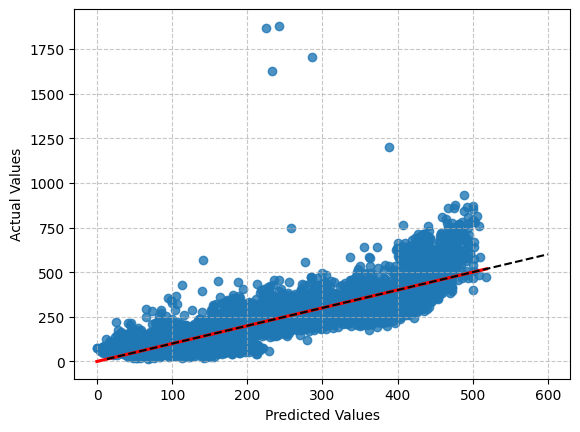

In [245]:
# Plotting the predicted vs actual values
sns.regplot(x=predicted, y=actual, line_kws={"color": "red"})
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.grid(alpha=0.7, linestyle='--')
# adding the perfect y=x line
min = actual.min()
max = 600
plt.plot([min, max], [min, max], color='black', linestyle='--')